# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [13]:
student1 = "Vincent Rinaldi"
student2 = "Thevie Mortiniera"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [14]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

### Plotting

In [15]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, 
    select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', # Removed "+1" of "(label_mapping[j]+1)%10" argument
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red', # Removed "+1" of "(label_mapping[k]+1)%10" argument
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [16]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

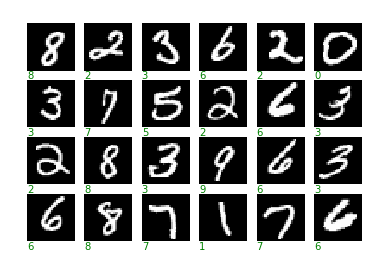

In [5]:
fig_mnist = plot_some_samples(x_train, y=y_train)

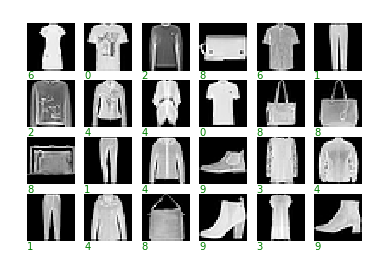

In [6]:
fig_fashion = plot_some_samples(x_fashion_train, y=y_fashion_train)

Answer to question 2:

The green digits at the bottom left of each image indicate the corresponding associated class label for each image.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [17]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [18]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 
                                          x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 
                                        x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [19]:
def network(x_tr, y_tr, x_v, y_v, n_layers=0, units=128, layer_activation='relu', 
            output_activation='softmax', loss='categorical_crossentropy', metric='accuracy', 
            lr=[0.1], optimizer=SGD, batch_size=128, n_epochs=50, title='MNIST dataset prediction', 
            num_classes=10, summary=False, h=False, plot_misclassified=False, early_stopping=False) :
    
    model = Sequential() # 28 * 28 = 784 input weights + 1 weight of connection with bias = 785 parameters for each hidden unit
    for l in range(n_layers) :
        model.add(Dense(units, activation=layer_activation)) # Hidden layer
    model.add(Dense(num_classes, activation=output_activation)) # Output layer
    
    history = None
    for l in lr :
        model.compile(optimizer=optimizer(l), loss=loss, metrics=[metric])
        if(early_stopping) : # If asked to perform early stopping
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
            history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=n_epochs, 
                                validation_data=(x_v, y_v), verbose=0, callbacks=[es])
        else :
            history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=n_epochs, validation_data=(x_v, y_v), verbose=0)
        if(h) : # If asked to plot history
            if(n_layers > 0) :
                plot_history(history, title + 
                             " with learning rate = {} and {} hidden layer(s) with {} unit(s) each".format(l, n_layers, units))
            else :
                plot_history(history, title + " with learning rate = {}".format(l))
    
    if(summary) : # If asked to print summary
        print(model.summary())
    
    if(len(lr) == 1 and plot_misclassified == True) :
        prediction = model.predict_classes(x_v)
        arr = np.zeros((y_v.shape))
        for k in range(len(prediction)) :
            v = prediction[k]
            arr[k, v] = 1
        error_indices = np.where(arr != y_v) # Gather misclassified indices
        list_error_indices = sorted(list(set(error_indices[0]))) # Remove duplicates and sort in ascending order
        print("Number of misclassified images : {}".format(len(list_error_indices)))
        plot_some_samples(x_v, y=y_v, yhat=arr, select_from=list_error_indices)
        
    return history

Number of misclassified images : 745


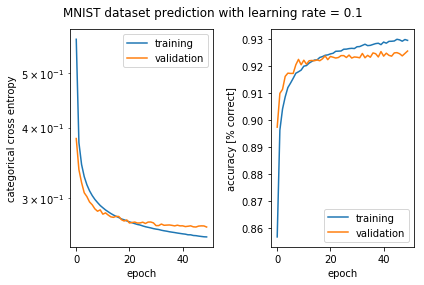

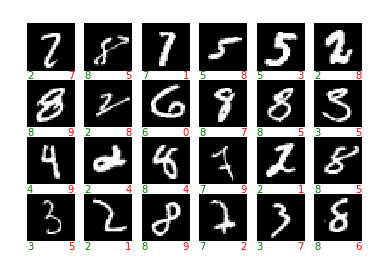

In [36]:
network(x_train, y_train, x_test, y_test, h=True, plot_misclassified=True)

Number of misclassified images : 1562


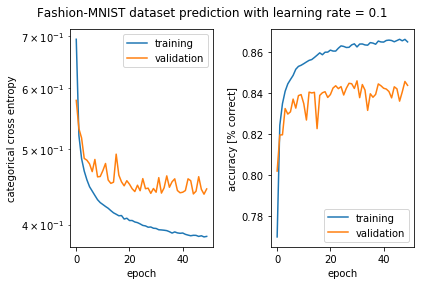

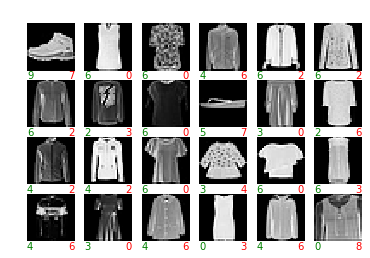

In [11]:
network(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
        title='Fashion-MNIST dataset prediction', h=True, plot_misclassified=True)

Answer to question 8:

For each image the green digits are their corresponding associated class label and the red ones are their predicted ones resulting from our fitted model : in this exercise, we are plotting only misclassified images.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


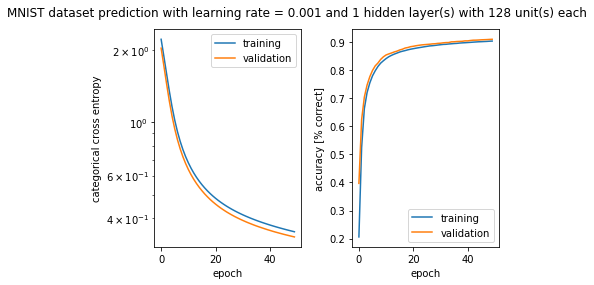

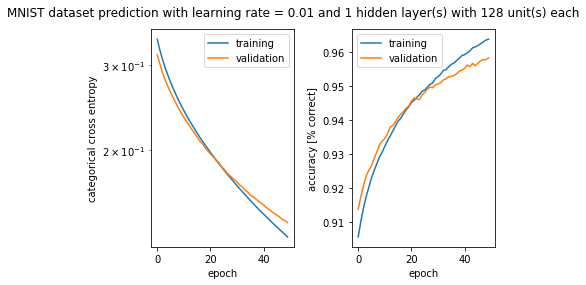

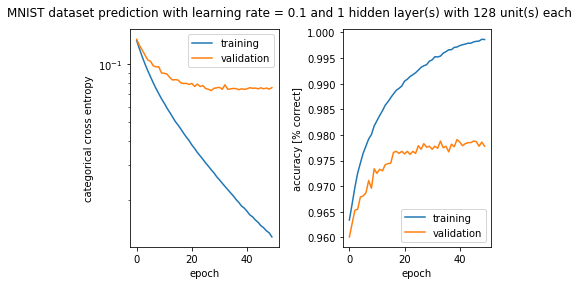

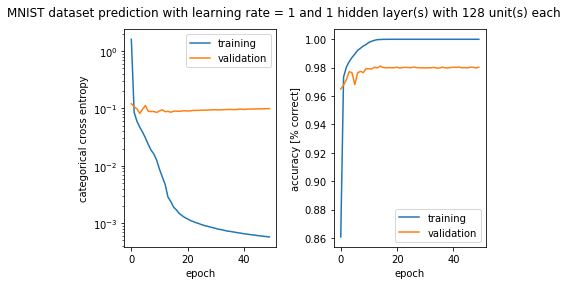

In [12]:
network(x_train, y_train, x_test, y_test, n_layers=1, lr=[0.001, 0.01, 0.1, 1], summary=True, h=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


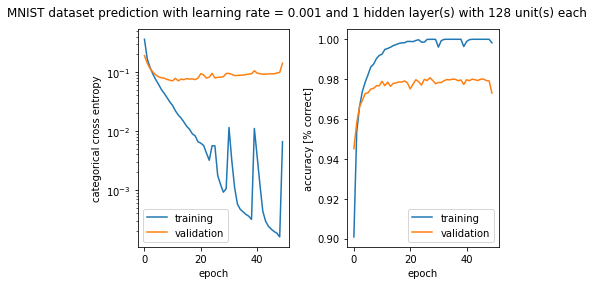

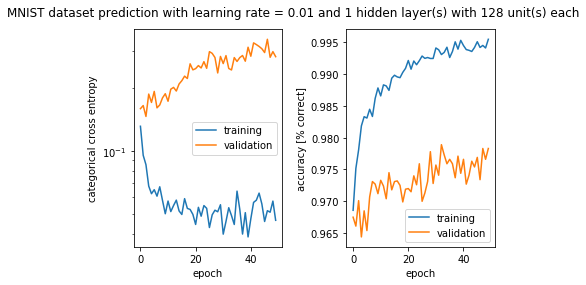

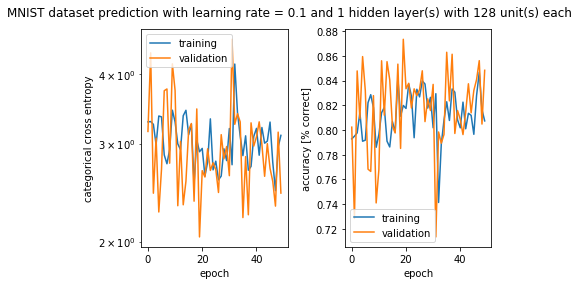

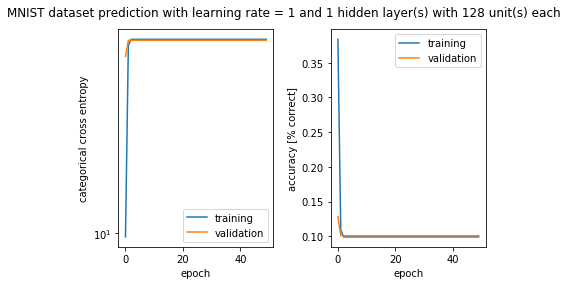

In [13]:
network(x_train, y_train, x_test, y_test, n_layers=1, optimizer=Adam, lr=[0.001, 0.01, 0.1, 1], summary=True, h=True)

In [14]:
history_sgd = network(x_train, y_train, x_test, y_test, 
                      n_layers=1, lr=[0.01], summary=True)

history_adam = network(x_train, y_train, x_test, y_test, 
                       n_layers=1, optimizer=Adam, lr=[0.01], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

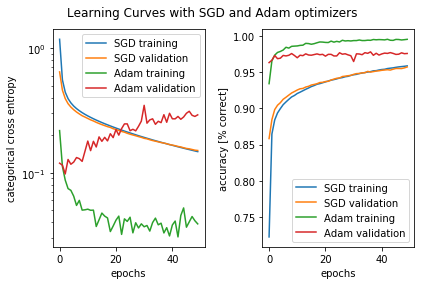

In [16]:
fig_comparison = comparison_plot(history_sgd, history_adam, 'SGD', 'Adam', 'Learning Curves with SGD and Adam optimizers')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


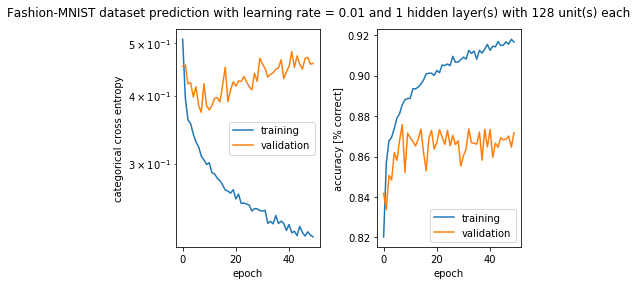

In [17]:
network(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
        n_layers=1, optimizer=Adam, lr=[0.01], title='Fashion-MNIST dataset prediction', summary=True, h=True)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) If the learning rate of SGD is very large (example : 1 or 0.1) the learning curves for the loss and accuracy scores converge quickly but oscillate, showing that the performance of the model is affected over the training epochs : with a very large learning rate, we may arrive at a sub-optimal final set of weights.

B) If the learning rate of SGD is very small (example : 0.01 or 0.001) the learning curves for the loss and accuracy scores converge slowly and so require more training epochs to reach an optimal result given the smaller changes made to the weights at each update : it may allow the model to learn a more optimal or even globally optimal set of weights but can take significantly longer training time.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: According to our results, a learning rate of 0.1 and 1 is too high for the Adam optimizer because of the numerous huge oscillations (or because of a very bad validation score), so if we analyse the learning curves for a learning rate of 0.001 and 0.01, we can see that the validation loss starts increasing at approximately 10 epochs, whereas at the same time the training loss is still decreasing, which are signs of overfitting (however, concerning the validation accuracy, it's still increasing after 10 epochs).

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: When the model is improving and gets more confident in terms of predictions, both loss curves (training and validation ones) decrease and so the loss gets better, until a point where the model starts to overfit : the validation loss curve will start to increase whereas the training one will continue to decrease, meaning that the model is being overtrained, and will match so much the training set that it won't be able to predict well new datapoints not belonging to this training set (the model will become overconfident). However, the score of the validation accuracy curve doesn't behave as we might expect : since the accuracy curves are still increasing even when overfitting occurs, this means that in an overconfident (or overtrained) model, we can still have good accuracy but bad loss. Indeed, since a few samples in the validation set are quite similar to samples in the training set, as training goes on, the model learns to recognize those samples, improving the accuracy, while the loss it incurs into when it makes mistakes becomes larger because of overfitting.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

Epoch 00107: early stopping
Best validation loss for 50 neurons = 0.13211321030557155 at epoch 7
Best validation accuracy for 50 neurons = 0.9733 at epoch 54
Epoch 00103: early stopping
Best validation loss for 100 neurons = 0.10434995681531728 at epoch 3
Best validation accuracy for 100 neurons = 0.981 at epoch 82
Epoch 00102: early stopping
Best validation loss for 150 neurons = 0.11060434121638536 at epoch 2
Best validation accuracy for 150 neurons = 0.9814 at epoch 97
Epoch 00103: early stopping
Best validation loss for 200 neurons = 0.11164000051617623 at epoch 3
Best validation accuracy for 200 neurons = 0.9796 at epoch 92
Epoch 00102: early stopping
Best validation loss for 250 neurons = 0.09515794925391674 at epoch 2
Best validation accuracy for 250 neurons = 0.9797 at epoch 46


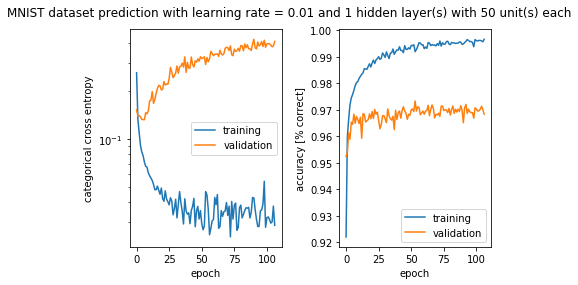

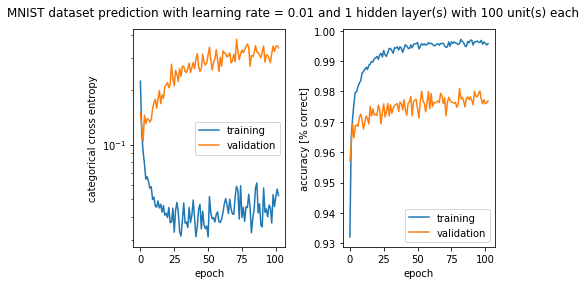

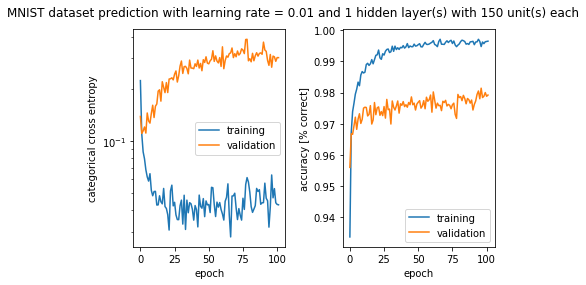

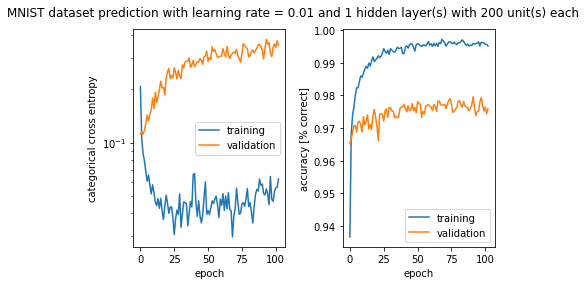

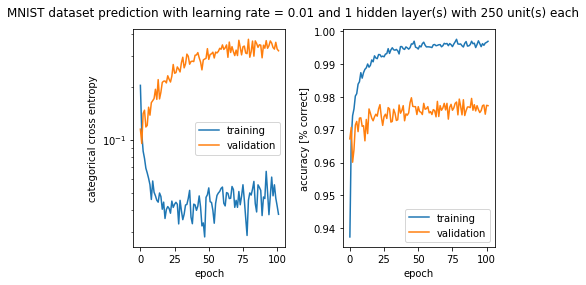

In [39]:
N = [50, 100, 150, 200, 250]
histories_loss_es = []
histories_acc_es = []
for n in N : # MNIST with early stopping
    hist = network(x_train, y_train, x_test, y_test, 
                   n_layers=1, units=n, optimizer=Adam, lr=[0.01], n_epochs=125, h=True, early_stopping=True)
    histories_loss_es.append(min(hist.history['val_loss']))
    print("Best validation loss for {} neurons = {} at epoch {}".format(n, min(hist.history['val_loss']), 
                                                                        hist.history['val_loss'].index(
                                                                            min(hist.history['val_loss']))+1))
    histories_acc_es.append(max(hist.history['val_acc']))
    print("Best validation accuracy for {} neurons = {} at epoch {}".format(n, max(hist.history['val_acc']), 
                                                                            hist.history['val_acc'].index(
                                                                                max(hist.history['val_acc']))+1))

Text(0, 0.5, 'Best validation loss')

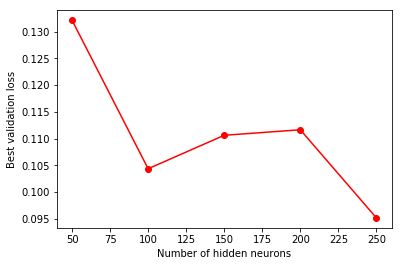

In [40]:
plt.plot(N, histories_loss_es, color='red', marker='o')
plt.xlabel('Number of hidden neurons')
plt.ylabel('Best validation loss')

Text(0, 0.5, 'Best validation accuracy')

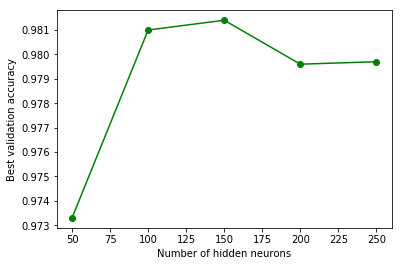

In [41]:
plt.plot(N, histories_acc_es, color='green', marker='o')
plt.xlabel('Number of hidden neurons')
plt.ylabel('Best validation accuracy')

Epoch 00109: early stopping
Best validation loss for 50 neurons = 0.3954745500087738 at epoch 9
Best validation accuracy for 50 neurons = 0.8713 at epoch 40
Epoch 00104: early stopping
Best validation loss for 100 neurons = 0.3811223840236664 at epoch 4
Best validation accuracy for 100 neurons = 0.8797 at epoch 46
Epoch 00110: early stopping
Best validation loss for 150 neurons = 0.37974543342590333 at epoch 10
Best validation accuracy for 150 neurons = 0.8746 at epoch 26
Epoch 00106: early stopping
Best validation loss for 200 neurons = 0.37714245722293854 at epoch 6
Best validation accuracy for 200 neurons = 0.8775 at epoch 51
Epoch 00111: early stopping
Best validation loss for 250 neurons = 0.38263671774864194 at epoch 11
Best validation accuracy for 250 neurons = 0.8787 at epoch 43


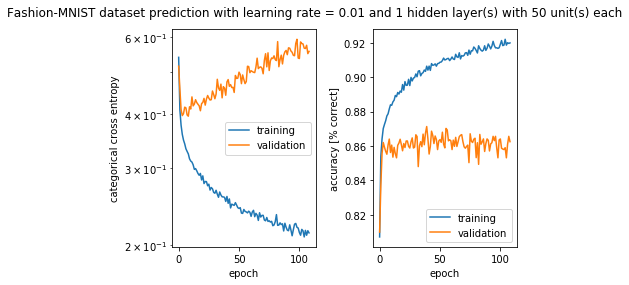

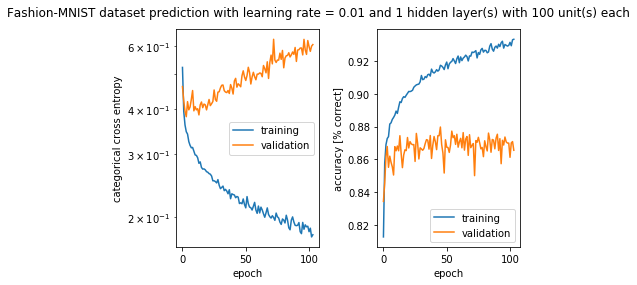

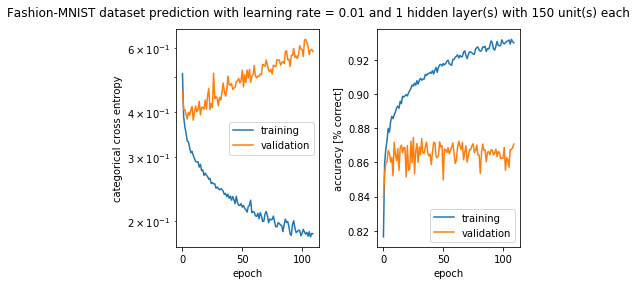

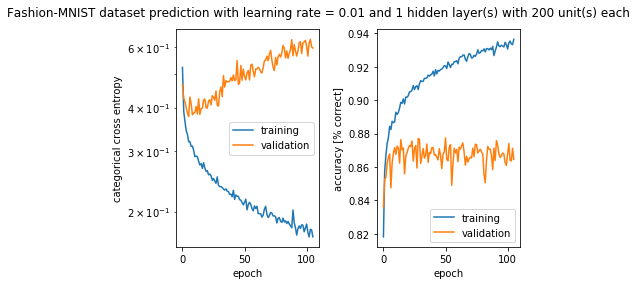

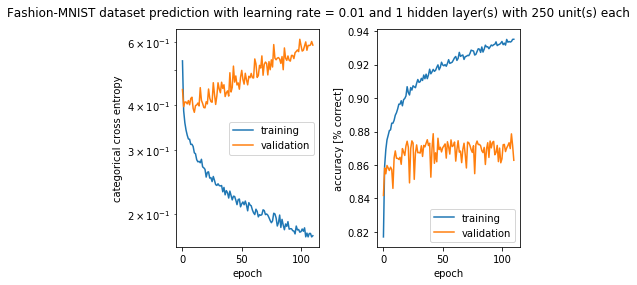

In [22]:
N = [50, 100, 150, 200, 250]
histories_loss_fashion_es = []
histories_acc_fashion_es = []
for n in N : # Fashion-MNIST with early stopping
    hist = network(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
                   n_layers=1, units=n, optimizer=Adam, lr=[0.01], n_epochs=125, 
                   title='Fashion-MNIST dataset prediction', h=True, early_stopping=True)
    histories_loss_fashion_es.append(min(hist.history['val_loss']))
    print("Best validation loss for {} neurons = {} at epoch {}".format(n, min(hist.history['val_loss']), 
                                                                        hist.history['val_loss'].index(
                                                                            min(hist.history['val_loss']))+1))
    histories_acc_fashion_es.append(max(hist.history['val_acc']))
    print("Best validation accuracy for {} neurons = {} at epoch {}".format(n, max(hist.history['val_acc']), 
                                                                            hist.history['val_acc'].index(
                                                                                max(hist.history['val_acc']))+1))

Text(0, 0.5, 'Best validation loss')

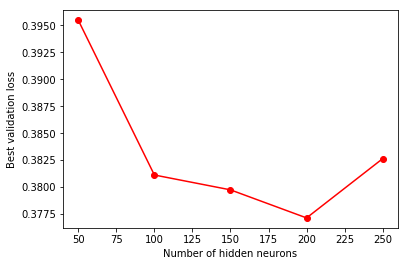

In [23]:
plt.plot(N, histories_loss_fashion_es, color='red', marker='o')
plt.xlabel('Number of hidden neurons')
plt.ylabel('Best validation loss')

Text(0, 0.5, 'Best validation accuracy')

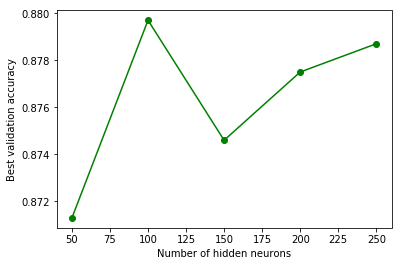

In [24]:
plt.plot(N, histories_acc_fashion_es, color='green', marker='o')
plt.xlabel('Number of hidden neurons')
plt.ylabel('Best validation accuracy')

Answer to question 2: The General Approximation Theorem states that standard feedforward neural networks with a single hidden layer containing a finite number of neurons and arbitrary bounded nonlinear activation functions can uniformly approximate arbitrary bounded continuous functions on finite subsets of $\mathbb{R}^{n}$ with any precision : you can always come up with a deep neural network that will approximate any complex relation between input and output. According to our loss/accuracy scores versus the number of hidden neurons in our single hidden layer, we get pretty close results and similar learning curves, independently on the number of hidden neurons : any complex relation between input and output can then be approximated, and so the observed trend is in accordance with the General Approximation Theorem.  

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [21]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers

In [22]:
def optimize(x_tr, y_tr, x_v, y_v, 
             n_layers=0, units=128, 
             layer_activation='relu', output_activation='softmax', loss='categorical_crossentropy', metric='accuracy', 
             lr=[0.1], optimizer=SGD, batch_size=128, n_epochs=50, title='Fashion-MNIST dataset prediction', num_classes=10, 
             h=False, early_stopping=False, 
             batch_normalization=False, dropout=False, regularizer=-1, kernel_reg=False, bias_reg=False) :
    
    model = Sequential()
    
    for l in range(n_layers) : # Hidden layers
        if(batch_normalization == True) :
            model.add(BatchNormalization())
        if(regularizer == -1 or (kernel_reg == False and bias_reg == False)) : # No Regularizer
            model.add(Dense(units, activation=layer_activation))
        elif(regularizer == 0) : # Both L1 & L2 Regularizers
            if(kernel_reg == True and bias_reg == False) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
            elif(kernel_reg == False and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
            elif(kernel_reg == True and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), 
                                bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
        elif(regularizer == 1) : # L1 Regularizer
            if(kernel_reg == True and bias_reg == False) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l1(0.01)))
            elif(kernel_reg == False and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                bias_regularizer=regularizers.l1(0.01)))
            elif(kernel_reg == True and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l1(0.01), 
                                bias_regularizer=regularizers.l1(0.01)))
        elif(regularizer == 2) : # L2 Regularizer
            if(kernel_reg == True and bias_reg == False) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l2(0.01)))
            elif(kernel_reg == False and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                bias_regularizer=regularizers.l2(0.01)))
            elif(kernel_reg == True and bias_reg == True) :
                model.add(Dense(units, activation=layer_activation, 
                                kernel_regularizer=regularizers.l2(0.01), 
                                bias_regularizer=regularizers.l2(0.01)))
        if(dropout == True) :
            model.add(Dropout(0.5))
    
    if(batch_normalization == True) :
        model.add(BatchNormalization())
    model.add(Dense(num_classes, activation=output_activation)) # Output layer
    
    history = None
    for l in lr :
        model.compile(optimizer=optimizer(l), loss=loss, metrics=[metric])
        if(early_stopping) : # If asked to perform early stopping
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
            history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=n_epochs, 
                                validation_data=(x_v, y_v), verbose=0, callbacks=[es])
        else :
            history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=n_epochs, validation_data=(x_v, y_v), verbose=0)
        if(h) : # If asked to plot history
            if(n_layers > 0) :
                plot_history(history, title + 
                             " with learning rate = {} and {} hidden layer(s) with {} unit(s) each".format(l, n_layers, units))
            else :
                plot_history(history, title + " with learning rate = {}".format(l))
        
    return history

Epoch 00114: early stopping
Best validation loss = 0.36413846230506897 at epoch 14
Best validation accuracy = 0.8782 at epoch 29


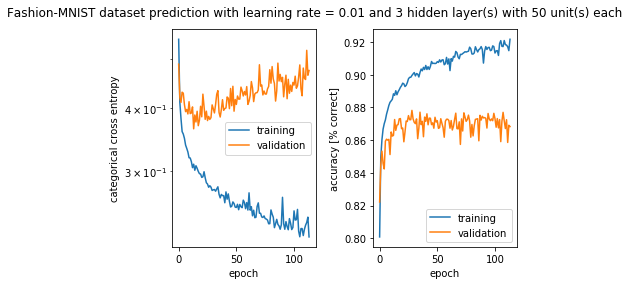

In [37]:
history_naive_loss_fashion_es = []
history_naive_acc_fashion_es = []
history_naive = optimize(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
                        n_layers=3, units=50, optimizer=Adam, lr=[0.01], n_epochs=125, h=True, early_stopping=True)
history_naive_loss_fashion_es.append(min(history_naive.history['val_loss']))
print("Best validation loss = {} at epoch {}".format(min(history_naive.history['val_loss']), 
                                                         history_naive.history['val_loss'].index(
                                                         min(history_naive.history['val_loss']))+1))
history_naive_acc_fashion_es.append(max(history_naive.history['val_acc']))
print("Best validation accuracy = {} at epoch {}".format(max(history_naive.history['val_acc']), 
                                                             history_naive.history['val_acc'].index(
                                                             max(history_naive.history['val_acc']))+1))

Epoch 00111: early stopping
Best validation loss = 0.3398876709461212 at epoch 11
Best validation accuracy = 0.8885 at epoch 33


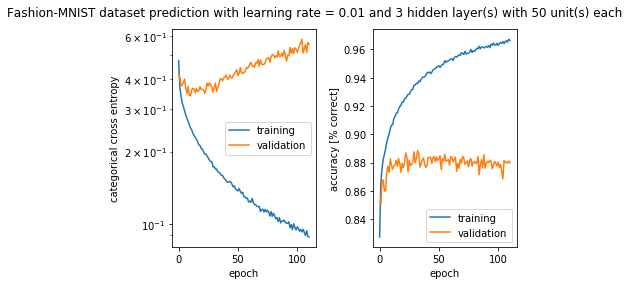

In [32]:
history_tuned_loss_fashion_es = []
history_tuned_acc_fashion_es = []
history_tuned = optimize(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
                        n_layers=3, units=50, optimizer=Adam, lr=[0.01], n_epochs=125, h=True, early_stopping=True, 
                        batch_normalization=True, regularizer=2, bias_reg=True)
history_tuned_loss_fashion_es.append(min(history_tuned.history['val_loss']))
print("Best validation loss = {} at epoch {}".format(min(history_tuned.history['val_loss']), 
                                                         history_tuned.history['val_loss'].index(
                                                         min(history_tuned.history['val_loss']))+1))
history_tuned_acc_fashion_es.append(max(history_tuned.history['val_acc']))
print("Best validation accuracy = {} at epoch {}".format(max(history_tuned.history['val_acc']), 
                                                             history_tuned.history['val_acc'].index(
                                                             max(history_tuned.history['val_acc']))+1))

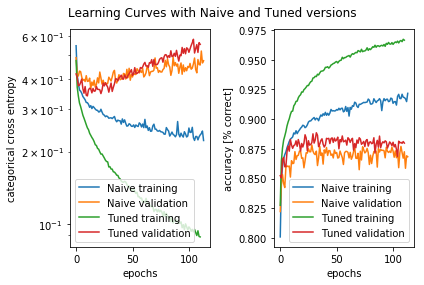

In [38]:
fig_observation = comparison_plot(history_naive, history_tuned, 
                                  'Naive', 'Tuned', 'Learning Curves with Naive and Tuned versions')

Epoch 00105: early stopping
Best validation loss = 0.0946568645782303 at epoch 5
Best validation accuracy = 0.9804 at epoch 92


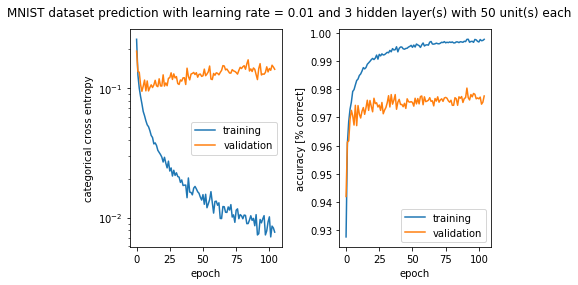

In [34]:
history_loss_es = []
history_acc_es = []
hist = optimize(x_train, y_train, x_test, y_test, 
                n_layers=3, units=50, optimizer=Adam, lr=[0.01], n_epochs=125, title='MNIST dataset prediction', 
                h=True, early_stopping=True, 
                batch_normalization=True, regularizer=2, bias_reg=True)
history_loss_es.append(min(hist.history['val_loss']))
print("Best validation loss = {} at epoch {}".format(min(hist.history['val_loss']), 
                                                         hist.history['val_loss'].index(
                                                         min(hist.history['val_loss']))+1))
history_acc_es.append(max(hist.history['val_acc']))
print("Best validation accuracy = {} at epoch {}".format(max(hist.history['val_acc']), 
                                                             hist.history['val_acc'].index(
                                                             max(hist.history['val_acc']))+1))

Answer to question 2 (comments): Even if the validation loss and accuracy scores of both versions are pretty close, we were able to bring minor improvement to our naive model by playing with batch normalization layers and L2-regularization on biases : the tuned version reaches a better validation loss and accuracy score than the naive one, converges faster to its optimal solution, thanks especially to batch normalization layers, and has a lower training error thanks to bias regularization. We also observe that for both models, their best validation loss score is better than those of the models having only one hidden layer (and more hidden neurons), which shows that having multiple layers makes our network more eager to recognize certain aspects of input data : multiple hidden layers are needed in order to learn more detailed relationships within the features and improve model fitting.

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Inspiration and Sources :

https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/

https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

In [23]:
from keras import backend as K
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D

In [30]:
def cnn_network(x_tr, y_tr, x_v, y_v, 
                batch_size=128, num_classes=10, optimizer=SGD, lr=0.01, n_epochs=20, norm=False, activation='relu') :
    
    # The image data format put the channel in last position
    # K.image_data_format() == channels_last
    x_tr = x_tr.reshape(x_tr.shape[0], 28, 28, 1)
    x_v = x_test.reshape(x_v.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
    model = Sequential()
    
    if(norm) :
        model.add(BatchNormalization())
    
    # 32 output channels and 5x5 filter/kernel size with 1 stride
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation=activation, input_shape=input_shape))
    
    # Max Pooling sliding window of size 2X2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    if(norm) :
        model.add(BatchNormalization())
    
    # 64 output channels and strides is equal to pool size by default
    model.add(Conv2D(64, (5, 5), activation=activation))        
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))
    
    # Flatten the output from the convolutional layers to enter our fully connected layers 
    model.add(Flatten())
    
    if(norm) :
        model.add(BatchNormalization())
    
    # Declare our fully connected layers with 325 nodes
    model.add(Dense(325, activation=activation))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr), metrics=['accuracy'])
    
    # Train the model
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=n_epochs, 
                        verbose=1, validation_data=(x_v, y_v), callbacks=[es])
    
    return history

In [26]:
history = cnn_network(x_train, y_train, x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 145s 2ms/step - loss: 1.4382 - acc: 0.5281 - val_loss: 0.3976 - val_acc: 0.8941
Epoch 2/20
60000/60000 [==============================] - 161s 3ms/step - loss: 0.4794 - acc: 0.8512 - val_loss: 0.2258 - val_acc: 0.9349
Epoch 3/20
60000/60000 [==============================] - 153s 3ms/step - loss: 0.3297 - acc: 0.8998 - val_loss: 0.1707 - val_acc: 0.9496
Epoch 4/20
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2649 - acc: 0.9212 - val_loss: 0.1413 - val_acc: 0.9572
Epoch 5/20
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2282 - acc: 0.9300 - val_loss: 0.1192 - val_acc: 0.9630
Epoch 6/20
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2014 - acc: 0.9387 - val_loss: 0.1060 - val_acc: 0.9669
Epoch 7/20
60000/60000 [==============================] - 142s 2ms/step - loss: 0.1782 - acc: 0.9461 - val_loss: 0.0980 - 

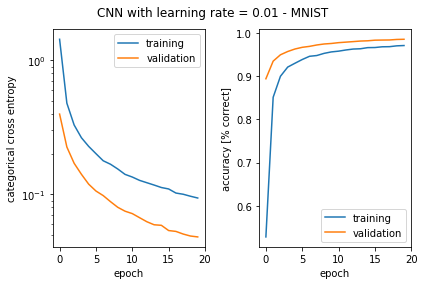

In [29]:
fig_cnn_mnist = plot_history(history, "CNN with learning rate = {} - MNIST".format(0.01))

In [31]:
history = cnn_network(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 108s 2ms/step - loss: 1.5703 - acc: 0.4451 - val_loss: 3.1811 - val_acc: 0.1002
Epoch 2/20
60000/60000 [==============================] - 129s 2ms/step - loss: 0.8622 - acc: 0.6807 - val_loss: 3.8453 - val_acc: 0.1007
Epoch 3/20
60000/60000 [==============================] - 157s 3ms/step - loss: 0.7347 - acc: 0.7254 - val_loss: 4.2935 - val_acc: 0.0993
Epoch 4/20
60000/60000 [==============================] - 166s 3ms/step - loss: 0.6741 - acc: 0.7490 - val_loss: 4.5443 - val_acc: 0.0997
Epoch 5/20
60000/60000 [==============================] - 181s 3ms/step - loss: 0.6357 - acc: 0.7611 - val_loss: 4.7620 - val_acc: 0.1010
Epoch 6/20
60000/60000 [==============================] - 157s 3ms/step - loss: 0.6053 - acc: 0.7741 - val_loss: 4.8181 - val_acc: 0.1000
Epoch 00006: early stopping


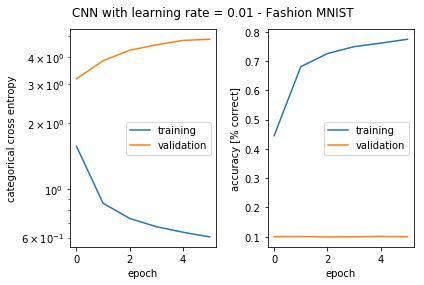

In [32]:
fig_cnn_fashion = plot_history(history, "CNN with learning rate = {} - Fashion MNIST".format(0.01))

Answer to question 3:

For the MNIST dataset, our best previous model for the accuracy was the one having one hidden layer and 150 neurons in it with a validation score of 0.9814 calculated in 97 epochs, while our CNN outperformed it, reaching an accuracy validation score of 0.9855 in only 20 epochs, which is however not the case for the Fashion-MNIST dataset which seems to be not compatible for our CNN model, since its performances are quite poor with an accuracy validation score of 0.1 only (early stopping after 6 epochs), whereas our best previous model reached 0.8885 after 33 epochs (tuned one with batch normalization and bias regularization with three hidden layers and 50 neurons). Concerning the loss, for the MNIST dataset, the best previous model was the tuned one (batch normalization and bias regularization) with three hidden layers and 50 neurons in each of them with a validation score of 0.0946 reached after 5 epochs, that our CNN model also outperformed with a significant improved loss validation score of 0.0482 after 20 epochs, whereas, again, for the Fashion-MNIST dataset, we obtain a bad loss validation score of 4.8181 (early stopping after 6 epochs) which is really far from the best validation score of 0.3398 reached after 11 epochs by the same tuned model. 

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

We chose the MNIST dataset.

Q1: Convolutional Neural Network with sigmoid activation function.

In [33]:
history = cnn_network(x_train, y_train, x_test, y_test, activation='sigmoid')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 127s 2ms/step - loss: 2.4573 - acc: 0.1017 - val_loss: 2.3027 - val_acc: 0.1010
Epoch 2/20
60000/60000 [==============================] - 140s 2ms/step - loss: 2.3737 - acc: 0.0994 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 3/20
60000/60000 [==============================] - 152s 3ms/step - loss: 2.3388 - acc: 0.1016 - val_loss: 2.3010 - val_acc: 0.1028
Epoch 4/20
60000/60000 [==============================] - 164s 3ms/step - loss: 2.3239 - acc: 0.1008 - val_loss: 2.3007 - val_acc: 0.1135
Epoch 5/20
60000/60000 [==============================] - 184s 3ms/step - loss: 2.3163 - acc: 0.1036 - val_loss: 2.3007 - val_acc: 0.1135
Epoch 6/20
60000/60000 [==============================] - 181s 3ms/step - loss: 2.3122 - acc: 0.1027 - val_loss: 2.3009 - val_acc: 0.1135
Epoch 7/20
60000/60000 [==============================] - 176s 3ms/step - loss: 2.3093 - acc: 0.1026 - val_loss: 2.3007 - 

Answer to question 1: We observe that the model is very slow to learn good parameters as its performances on the validation set do not seem to significantly progress after 13 epochs.

Q2 : Convolutional Neural Network with sigmoid activation function and batch normalization.

In [34]:
history = cnn_network(x_train, y_train, x_test, y_test, activation='sigmoid', norm=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 192s 3ms/step - loss: 1.5924 - acc: 0.4691 - val_loss: 0.6487 - val_acc: 0.8609
Epoch 2/20
60000/60000 [==============================] - 188s 3ms/step - loss: 0.8103 - acc: 0.7520 - val_loss: 0.4095 - val_acc: 0.8997
Epoch 3/20
60000/60000 [==============================] - 184s 3ms/step - loss: 0.5773 - acc: 0.8276 - val_loss: 0.3033 - val_acc: 0.9231
Epoch 4/20
60000/60000 [==============================] - 178s 3ms/step - loss: 0.4559 - acc: 0.8643 - val_loss: 0.2402 - val_acc: 0.9363
Epoch 5/20
60000/60000 [==============================] - 181s 3ms/step - loss: 0.3748 - acc: 0.8898 - val_loss: 0.1968 - val_acc: 0.9455
Epoch 6/20
60000/60000 [==============================] - 181s 3ms/step - loss: 0.3172 - acc: 0.9073 - val_loss: 0.1687 - val_acc: 0.9518
Epoch 7/20
60000/60000 [==============================] - 185s 3ms/step - loss: 0.2794 - acc: 0.9168 - val_loss: 0.1493 - 

Answer to question 2: In opposition to the previous settings where the model was not making any real progress, it seems here that batch normalization helps solving the vanishing gradient problem since our model almost reached the same performances as the CNN of the previous exercise.

Extra experimentation : CNN with ReLu activation and batch normalization. One might be interested to observe the effect of batch normalization using the same settings as in the previous exercise.

In [18]:
history_test = cnn_network(x_train, y_train, x_test, y_test, norm=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.4676 - acc: 0.8548 - val_loss: 0.0913 - val_acc: 0.9729
Epoch 2/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1714 - acc: 0.9469 - val_loss: 0.0645 - val_acc: 0.9793
Epoch 3/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1333 - acc: 0.9591 - val_loss: 0.0528 - val_acc: 0.9823
Epoch 4/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1079 - acc: 0.9669 - val_loss: 0.0460 - val_acc: 0.9842
Epoch 5/20
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0964 - acc: 0.9702 - val_loss: 0.0405 - val_acc: 0.9864
Epoch 6/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0871 - acc: 0.9736 - val_loss: 0.0382 - val_acc: 0.9871
Epoch 7/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0805 - acc: 0.9739 - val_loss: 0.0367 - val_acc

Comment : As expected, using batch normalization improved our CNN model of the previous exercise, since it outperformed it in both loss and accuracy validation scores after a few training epochs (exactly 5).